# Development notebook for processing sexual dimorphism data

In [99]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

#note 25.03.24 - holoviews import causes bug where no plots are displayed...
#import holoviews as hv
#from holoviews.operation.datashader import datashade
#from holoviews import opts, dim
#from holoviews.operation.datashader import rasterize
#hv.extension('matplotlib')
#from colorcet import fire

import dimorph_processing as dp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data_loading)
3. [Filtering](#filtering)
    1. [Cell Exclusion](#cell_exclusion_l1)
    2. [Male vs. Female Gene Expression](#avg_bool_mf_df_sorted_l2)
    3. [Gene Exclusion](#gene_exclusion_l1)
4. [Feature Selection](feat_selection) 
    1. [CV analysis](#get_top_cv_genes)
5. [Preprocessing](#preprocessing) 
    1. [Log and Standerdize](#log_and_standerdize)
6. [Dimensionality Reduction](#dim_reduction)
    1. [PCA](#analyze_pca)
    2. [t-SNE](#tsne)
        1. [Computing Perplexity](#get_perplexity)
        2. [Visualization](#do_tsne)
        3. [Marker Gene Overlay](#tsne_marker)
7. [Clustering](#clustering)
    1. [DBSCAN](#dbscan)
        1. [Computing Epsilon](#get_epsilon)
        2. [Visualization](#do_dbscan)
8. [Sorting](#cluster_sort)
    1. [Inter Cluster Sorting](#inter_cluster_sort)
    2. [Intra Cluster Sorting](#intra_cluster_sort)
9. [Marker Genes](#markergenes)
    1. [Compute Markers](#compute_marker_genes)
    2. [Heatmap](marker_heatmap)

## Introduction <a name="introduction"></a>

Analysis notebook for processing sexual dimorphism data. Each processing step calls a function from dimorph_processing.py

## Data Loading <a name="data_loading"></a>

Intialize metadata (meta_data_df), gene expression data (df), boolean gene expression data (df_bool), and status tracking (status_df)

In [2]:
meta_data_df, df_orig, df_bool, status_df = dp.load_data(metadata_file = '/bigdata/isaac/meta_data_dict_040224.json', 
                                                         bigdata_file = '/bigdata/isaac/dimorph_df.feather')

In [3]:
df_orig.shape

(27933, 79613)

In [4]:
df_orig.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,0,2,0,0,1,3,2,0,...,1,0,1,0,2,1,1,0,0,0
0610009B22Rik,0,0,0,1,0,2,2,0,1,0,...,0,0,0,0,2,0,0,0,0,0
0610009L18Rik,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,1,0,0,0
0610009O20Rik,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0610010F05Rik,0,0,1,0,0,0,2,1,1,0,...,1,0,2,0,1,0,1,0,0,0


In [5]:
meta_data_df.shape

(27, 79613)

In [6]:
meta_data_df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCAAGTACTGTC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCAGTAACATAG-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,...,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGAGTGCTCGC-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2,TTTGTTGTCGAAGGAC-1_10X37_2,TTTGTTGTCTCTGCTG-1_10X37_2
Serial_Number,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,98.0,...,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0,68.0
Date_Captured,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,05/31/20,...,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25,2019-11-25
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,C57Bl/6,...,,,,,,,,,,


In [7]:
status_df

,completion_status
cell_exclusion (l1),NaN
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


## Filtering <a name="filtering"></a>

### Cell Exclusion <a name="cell_exclusion_l1"></a>

Calculate molecules/cell and genes/cell vectors, keep only cells with >2500 mol/cell and >2000 genes/cell

In [8]:
df, df_bool, meta_data_df, status_df = dp.cell_exclusion(threshold_m = 2500, 
                                                      threshold_g = 2000,
                                                      meta_data_df = meta_data_df,
                                                      df_bool = df_bool,
                                                      df = df_orig,
                                                      status_df = status_df)


Total cells reduced from 79613 to 43492


In [9]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [10]:
df.shape #rerun

(27933, 43492)

In [11]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),NaN
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


Sanity Check of known specific sex genes

In [12]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

True
True
True
True
True
True


### Male vs. Female Gene Expression <a name="avg_bool_mf_df_sorted_l2"></a>

num m cells: 19749 num f cells: 23743


<IPython.core.display.Javascript object>


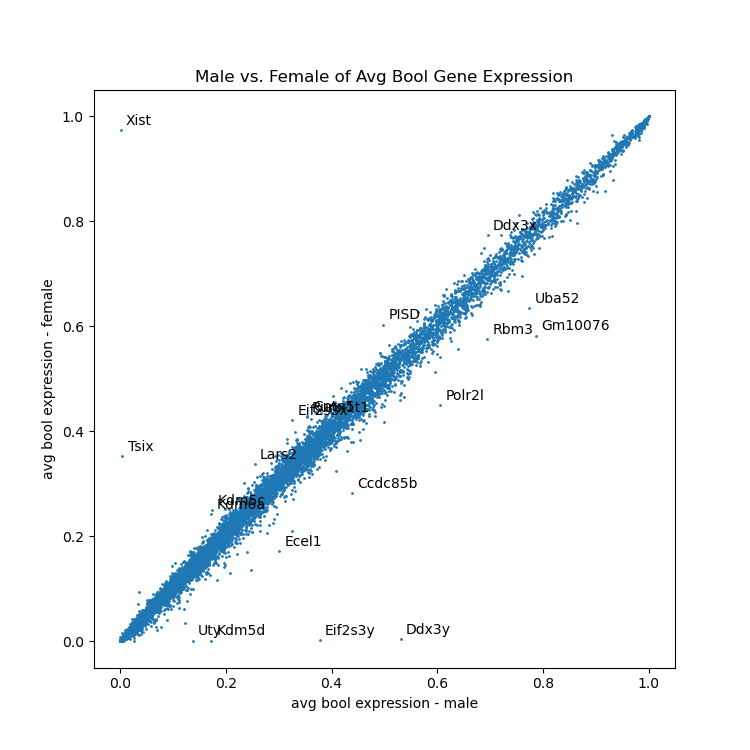

In [13]:
%matplotlib notebook
avg_bool_mf_df_sorted_l2 = dp.avg_bool_gene_expression_by_sex(df_bool = df_bool,
                                                              meta_data_df=meta_data_df,
                                                             num_top_genes=10,
                                                             plot_flag=1)

### Gene Exclusion <a name="gene_exclusion_l1"></a> 

Keep only genes expressed in >10 cells, <50% of all cells

In [14]:
df, df_bool, meta_data_df, status_df = dp.gene_exclusion(num_cell_lwr_bound=10,
                                                      percent_cell_upper_bound=50,
                                                     df_bool=df_bool,
                                                     df = df,
                                                     meta_data_df = meta_data_df,
                                                     status_df = status_df)
df.head()

Total genes reduced from 27933 to 17081


,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
0610007P14Rik,0,2,2,0,1,3,2,0,1,1,...,0,1,1,1,0,1,2,1,1,0
0610009B22Rik,0,0,1,2,2,0,1,0,0,0,...,1,0,0,0,0,0,2,0,0,0
0610009L18Rik,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
0610009O20Rik,1,0,0,1,1,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
0610010F05Rik,0,0,0,0,2,1,1,0,0,0,...,1,0,0,1,0,2,1,0,1,0


In [15]:
meta_data_df.shape

(27, 43492)

In [16]:
df.shape

(17081, 43492)

In [17]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,NaN
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


#### Sanity Check of known specific sex genes

In [18]:
print ('Xist' in df.index)
print ('Tsix' in df.index)
print ('Ddx3y' in df.index)
print ('Eif2s3y' in df.index)
print ('Kdm5d' in df.index)
print ('Uty' in df.index)

False
True
True
True
True
True


## Feature Selection <a name="feat_selection"></a> 

### CV Analysis <a name="get_top_cv_genes"></a> 

<IPython.core.display.Javascript object>


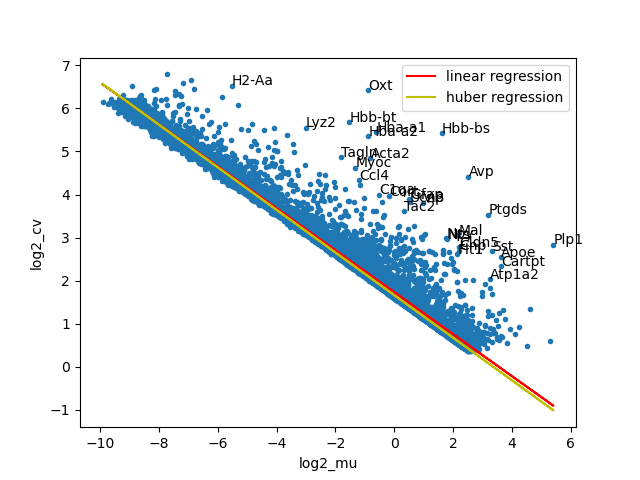

In [19]:
cv_df = dp.analyze_cv(df = df,
                      norm_scale_factor=20000,
                      num_top_genes=30,
                      plot_flag=1,
                     use_huber = True)

In [20]:
cv_df.head()

,log2mu,log2cv,delta_cv
gene,,,
Hbb-bs,1.620289,5.429946,4.570352
Oxt,-0.879842,6.428204,4.330631
Avp,2.526425,4.414903,4.003995
Plp1,5.415903,2.831623,3.851485
Hba-a1,-0.615138,5.448019,3.481519


In [21]:
cv_df.shape

(17081, 3)

Use highest variation CV genes to get top genes

<IPython.core.display.Javascript object>


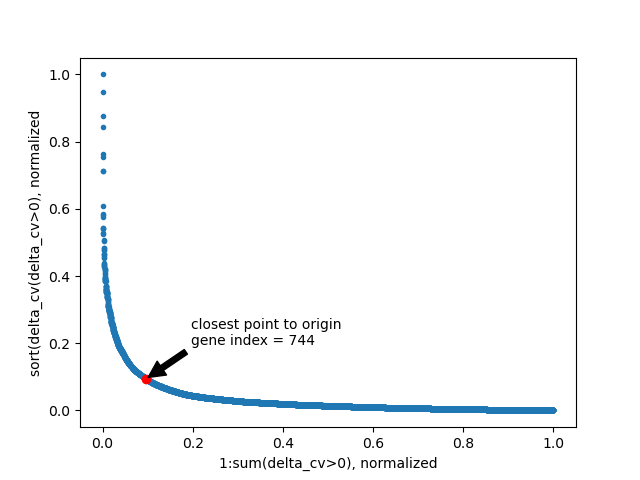

In [22]:
gene_index, df, status_df = dp.get_top_cv_genes(df = df, cv_df=cv_df, plot_flag=1, status_df=status_df)

In [23]:
df.shape

(744, 43492)

In [24]:
gene_index

744

In [25]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,NaN
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


utilize mean-variance relationship (PCA). Why this as opposed t mean-dropout relationship? see 'feature selection' section in :
https://www.nature.com/articles/s41467-019-13056-x

## Preprocessing <a name="preprocessing"></a> 

### Log and Standerdize <a name="#log_and_standerdize"></a> 

In [26]:
df.head()

,AAACCCAAGAGCATAT-1_10X51_2,AAACCCAAGCCTCAGC-1_10X51_2,AAACCCACACAACGTT-1_10X51_2,AAACCCATCACTAGCA-1_10X51_2,AAACGAACACTCCGAG-1_10X51_2,AAACGAACAGCGCGTT-1_10X51_2,AAACGAACAGGACTTT-1_10X51_2,AAACGAAGTGAATAAC-1_10X51_2,AAACGAAGTGACCTGC-1_10X51_2,AAACGCTAGCTCACTA-1_10X51_2,...,TTTGGAGGTGTGTCCG-1_10X37_2,TTTGGAGTCTCGCTTG-1_10X37_2,TTTGGTTTCCAATCTT-1_10X37_2,TTTGGTTTCCACGAAT-1_10X37_2,TTTGGTTTCTTTCTAG-1_10X37_2,TTTGTTGAGAAATTCG-1_10X37_2,TTTGTTGCAAGGTCAG-1_10X37_2,TTTGTTGCACCGCTGA-1_10X37_2,TTTGTTGGTCCATAGT-1_10X37_2,TTTGTTGGTTGCGAAG-1_10X37_2
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plp1,0,0,2,0,0,0,1,0,0,0,...,1,0,0,1,0,71,0,0,0,1
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
df.shape

(744, 43492)

In [28]:
log_std_arr,status_df = dp.log_and_standerdize_df(df,status_df)

column (gene) mean after standardization: 0.00
column (gene) sigma after standardization: 1.00


In [29]:
log_std_arr.shape

(43492, 744)

In [30]:
log_std_arr.shape

(43492, 744)

In [31]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,NaN
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


## Dimensionality Reduction <a name="dim_reduction"></a> 

### PCA <a name="analyze_pca"></a> 

Do PCA intially with num components = all genes, use normalized explained variance to select highest variation PCs and reduce gene expression to this dimension 

<IPython.core.display.Javascript object>


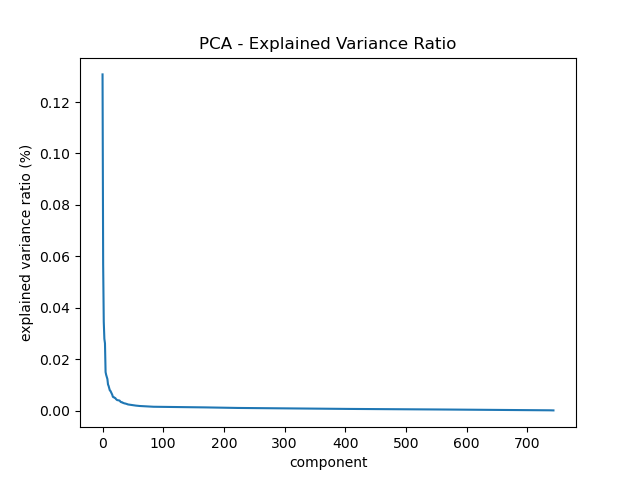

<IPython.core.display.Javascript object>


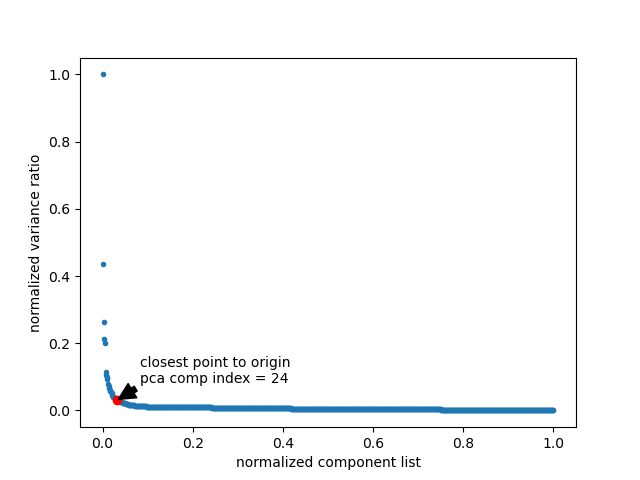

<IPython.core.display.Javascript object>


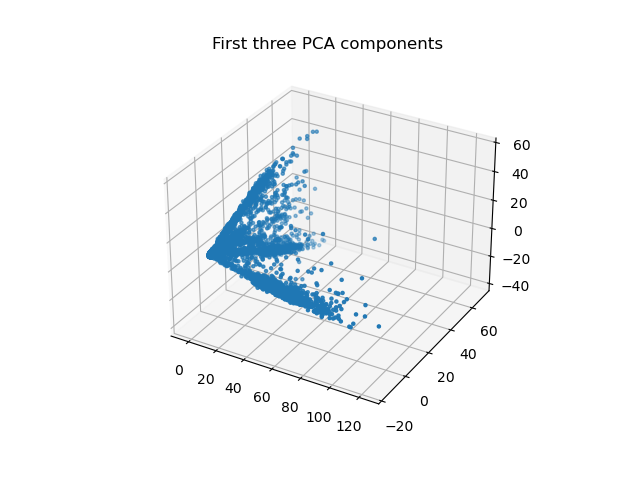

In [32]:
pca_index, arr_pca, status_df = dp.analyze_pca(arr = log_std_arr, #log_std_arr
                                               n_components=log_std_arr.shape[1], #log_std_arr.shape[1]
                                               optimize_n=True,
                                               plot_flag=1, 
                                               status_df=status_df)

In [33]:
arr_pca.shape

(43492, 24)

In [34]:
pca_index

24

In [35]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,NaN
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


In [36]:
'Apoe' in df.index

True

### t-SNE <a name="tsne"></a> 

#### Computing Perplexity <a name="get_perplexity"></a> 

Amit's method for determining perplexity param - 
1) compute pairwise distance matrix (n_cells x n_cells) from PCA reduced matrix.
2) sort columns by ascending values
3) compute angle from first point to last point of column values from index 1-500
4) use rotation matrix to rotate column values by this angle
5) take argmax for each rotated set of column values and store in list
6) take median of list created in step 5, this is perplexity value



<IPython.core.display.Javascript object>


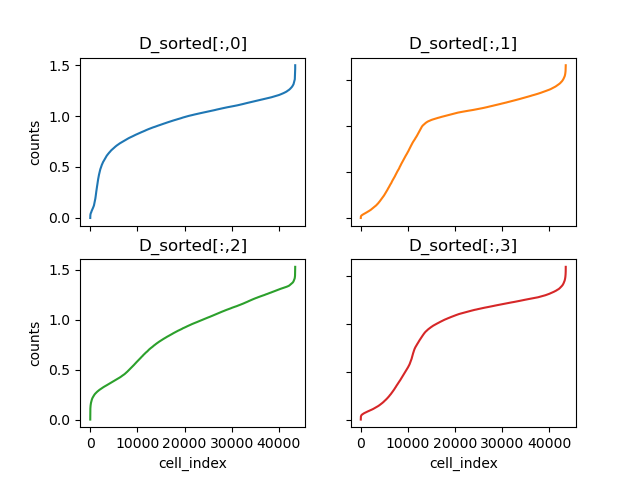

<IPython.core.display.Javascript object>


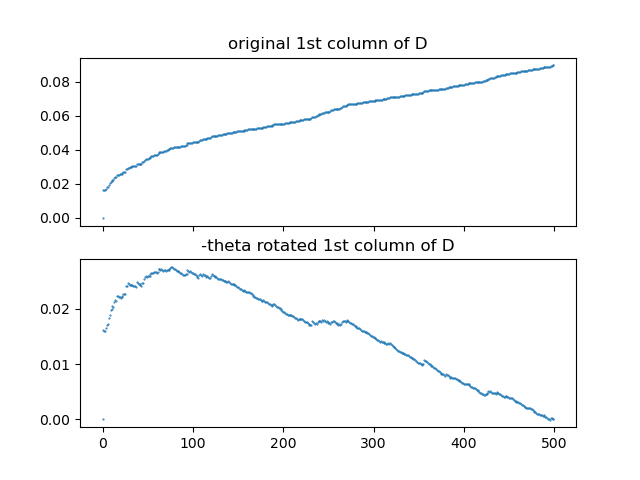

In [37]:
perplexity,status_df = dp.get_perplexity(pca_arr = arr_pca, cutoff=500, plot_flag=1, status_df = status_df)

In [38]:
perplexity

57.0

In [39]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,NaN
compute_eps,NaN
do_dbscan,NaN


#### Visualize with t-SNE<a name="do_tsne"></a> 

In [40]:
arr_pca.shape

(43492, 24)

Do TSNE on pca reduced matrix using calculated perplexity. See https://www.nature.com/articles/s41467-019-13056-x for more details on parameter selection.

Note sklearn's learning rate is defined factor of 4 smaller than other implementations, see sklearn doc: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Create a t-SNE object

creating tsne object with the following parameters: 
n_components:2
n_iter: 1000
learning_rate: 50
early_exaggeration: 12
init: pca
perplexity: 57.0


<IPython.core.display.Javascript object>


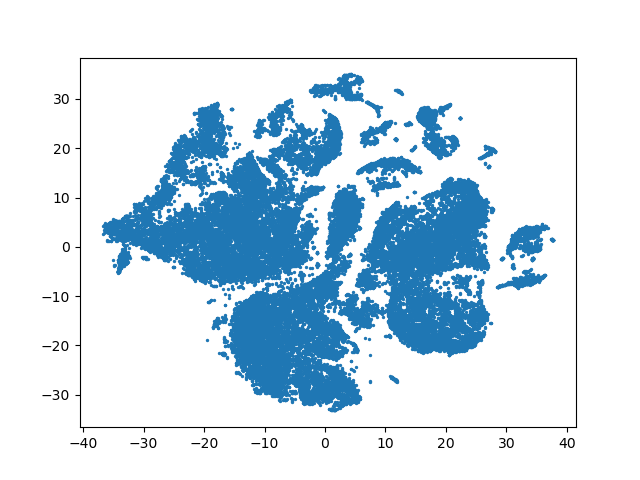

In [41]:
arr_tsne,status_df = dp.do_tsne(arr = arr_pca, 
                               n_components=2,
                               n_iter=1000,
                               learning_rate=50,
                               early_exaggeration=12,
                               init='pca', 
                               perplexity = perplexity,
                               status_df = status_df)

In [42]:
arr_tsne.shape

(43492, 2)

In [43]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,True
compute_eps,NaN
do_dbscan,NaN


#### Overlay tSNE with known marker genes <a name="tsne_marker"></a> 

As a sanity check, plot a positively expressed known marker gene on top of tSNE plot.
Known marker genes from: 
https://www.science.org/doi/full/10.1126/science.aaa1934)

In [44]:
tsne = TSNE(n_components=2,
            n_iter=1000,
            learning_rate=50,
           early_exaggeration=12,
           init='pca', 
           perplexity = perplexity)

# Apply t-SNE on the arr
X_tsne = tsne.fit_transform(arr_pca)

In [45]:
#Mpb, Gad1, Aldoc, Cldn5(good), Acta2 (good)

gene in df?  True
gene index:  [10]
num cells with positive expression of gene, Sst: 5021


<IPython.core.display.Javascript object>


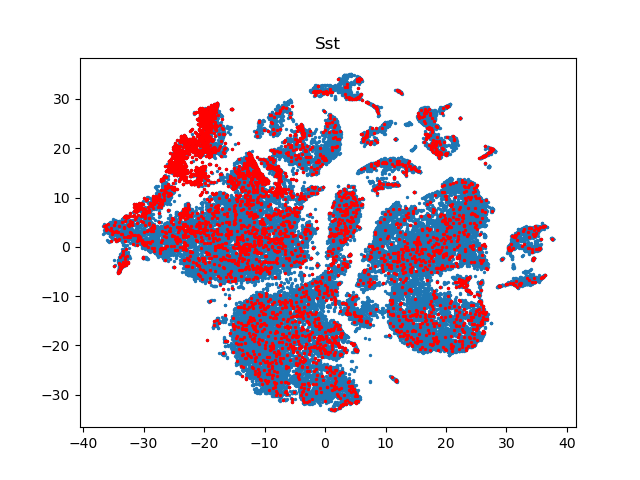

In [46]:
gene = 'Sst'
print('gene in df? ', gene in df.index)
print ('gene index: ', np.where(df.index == gene)[0])

#boolean array where True = gene postively expressed
x = df.iloc[np.where(df.index == gene)[0],:]>0
       
x_arr = x.to_numpy()
#use array of cell names to get cell index       
result = [idx for idx, val in enumerate(df.columns) if val in df.columns[x_arr[0]]]
print (f'num cells with positive expression of gene, {gene}:', len(result))

#visualise tsne
ax, fig = plt.subplots()
plt.title(gene)
fig.scatter(X_tsne[:, 0], X_tsne[:, 1], s = 2)
fig.scatter(X_tsne[result,0], X_tsne[result,1], s = 2, c = 'r')
plt.show()

In [50]:
status_df

,completion_status
cell_exclusion (l1),True
gene_exclusion (l1),True
get_top_cv_genes,True
log_and_standerdize,True
analyze_pca,True
get_perplexity,True
do_tsne,True
compute_eps,NaN
do_dbscan,NaN


## Clustering <a name="clustering"></a>

### DBSCAN <a name="dbscan"></a>

#### Computing Epsilon <a name="get_epsilon"></a> 

In [ ]:
epsilon, minpts, status_df = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne, status_df = status_df)

Alternative method for finding epsilon- calculate avg distance between each point and its n_neighbors (equal to min_pts), plot, and select point of max curvature 

In [52]:
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(arr_tsne)
distances, indices = neighbors_fit.kneighbors(arr_tsne)

In [53]:
distances = np.flip(np.sort(distances, axis=0))
distances_c1 = distances[:,1]
fig,ax = plt.subplots()
plt.plot(distances_c1)
plt.xlabel('index')
plt.ylabel('sorted distances (first column)')
plt.show()

<IPython.core.display.Javascript object>

#### Visualize DBScan Clusters <a name="do_dbscan"></a> 

Use scikit-learn implementaton: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Uncomment code below to perform dbscan clustering on range of minpts values: 10,15,20,25,30,35, with epsiolon computed for each. corresponding epsilon values for each

In [55]:
#for m in range(10,40,5):
    #epsilon, minpts = dp.compute_eps(minpts = m, eps_prc=90, arr= arr_tsne, status_df = status_df)
    #labels,n_clusters, arr = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne, status_df = status_df)

Pick case where minpts = 35

params for dbscan
minpts:  35
epsilon:  0.9425123540094148

running dbscan with epsilon: 0.9425123540094148  and minpts: 35
Estimated number of clusters: 31
Estimated number of noise points: 849


<IPython.core.display.Javascript object>


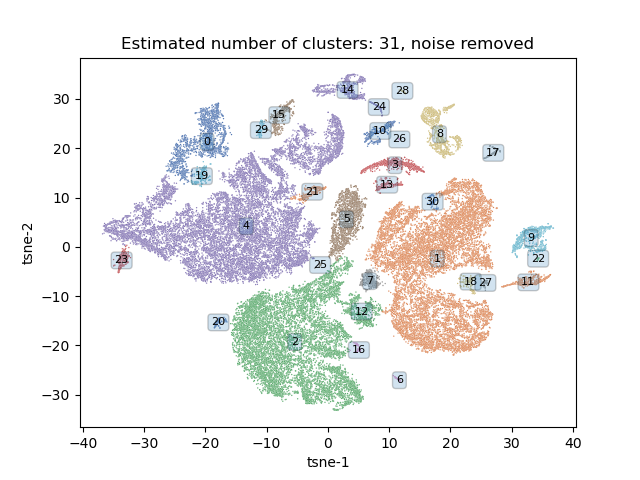

In [56]:
#epsilon, minpts, status_df = dp.compute_eps(minpts = 35, eps_prc=90, arr= arr_tsne, status_df = status_df)
labels, n_clusters_, arr_df, status_df = dp.do_dbscan(epsilon = epsilon, minpts = minpts, arr = arr_tsne, status_df = status_df)

In [57]:
#numpy method to get cluster and pts per cluster
#c,p = np.unique(labels,return_counts=True)

View histogram showing number of pts per cluster

<IPython.core.display.Javascript object>


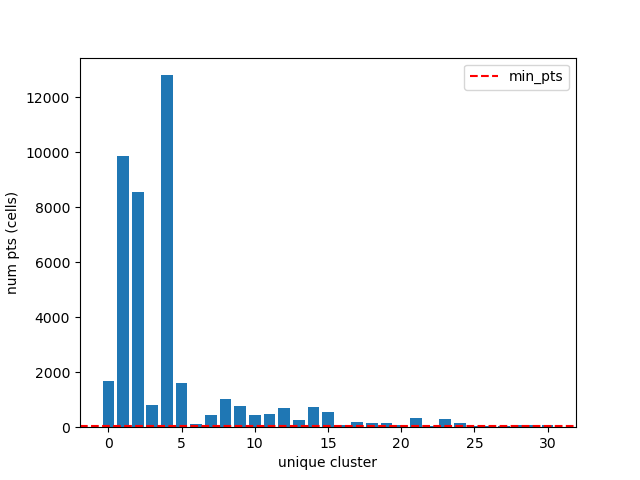

In [58]:
dp.histogram_pts_per_cluster(labels, minpts=minpts)

Reshuffle gene expression matrix, meta data using cluster labels

In [62]:
df_pre_linkage, meta_data_df, unique_labels = dp.sort_by_cluster_label(df,meta_data_df,arr_df,labels)

In [64]:
df_pre_linkage.head()

gene,Hbb-bs,Oxt,Avp,Plp1,Hba-a1,Ptgds,Hba-a2,Hbb-bt,Acta2,Apoe,...,Ccdc153,Fam64a,Hpgds,Asic4,Fgfbp1,Rps27rt,Prox1os,Tmem47,Tns4,Dusp2
AAACCCAAGAGCATAT-1_10X51_2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CACGAATGTTGTAGCT-1_10X51_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
AGAAATGTCGTGTGAT-1_10X51_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
TTTAGTCAGCACTGGA-1_10X36_1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TTTGATCTCACGGAGA-1_10X36_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
meta_data_df

,AAACCCAAGAGCATAT-1_10X51_2,CACGAATGTTGTAGCT-1_10X51_1,AGAAATGTCGTGTGAT-1_10X51_4,TTTAGTCAGCACTGGA-1_10X36_1,TTTGATCTCACGGAGA-1_10X36_1,AAACGCTCATGGCTGC-1_10X36_2,ACTTCGCCAAATACAG-1_10X51_4,TTGGTTTTCAGAATAG-1_10X51_1,CATACCCGTTTCGATG-1_10X35_2,ACTGCAATCGTAACAC-1_10X51_4,...,CATCCCAAGAGGCGTT-1_10X38_1,AGTCAACTCTAGCCAA-1_10X52_3,GGGTGAATCAGTGTTG-1_10X36_1,TCCTCGACACTACGGC-1_10X52_2,CGAGGAAAGCTACTGT-1_10X36_2,GAGTCATCAGAGTTGG-1_10X36_1,GTAGCTACACACAGAG-1_10X38_2,TGTAGACTCCTTATGT-1_10X52_2,GTCAAACCACTGCACG-1_10X36_1,TGAGGAGCAATACCCA-1_10X35_2
Serial_Number,98.0,97.0,100.0,65.0,65.0,66.0,100.0,97.0,64.0,100.0,...,69.0,103.0,65.0,102.0,66.0,65.0,70.0,102.0,65.0,64.0
Date_Captured,05/31/20,05/31/20,05/31/20,2019-11-24,2019-11-24,2019-11-24,05/31/20,05/31/20,2019-11-20,05/31/20,...,2019-12-01,05/31/20,2019-11-24,05/31/20,2019-11-24,2019-11-24,2019-12-01,05/31/20,2019-11-24,2019-11-20
Species,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,...,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm,Mm
Transcriptome,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,...,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10,Mm10
Strain,C57Bl/6,C57Bl/6,C57Bl/6,,,,C57Bl/6,C57Bl/6,,C57Bl/6,...,,C57Bl/6,,C57Bl/6,,,,C57Bl/6,,
Project,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,...,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph,Dimorph
Group,Breeder-F,Breeder-F,Breeder-M,Naïve-M,Naïve-M,Naïve-M,Breeder-M,Breeder-F,Naïve-F,Breeder-M,...,Naïve-F,Breeder-M,Naïve-M,Breeder-F,Naïve-M,Naïve-M,Naïve-F,Breeder-F,Naïve-M,Naïve-F
ChipID,10X51,10X51,10X51,10X36,10X36,10X36,10X51,10X51,10X35,10X51,...,10X38,10X52,10X36,10X52,10X36,10X36,10X38,10X52,10X36,10X35
SampleID,10X51_2,10X51_1,10X51_4,10X36_1,10X36_1,10X36_2,10X51_4,10X51_1,10X35_2,10X51_4,...,10X38_1,10X52_3,10X36_1,10X52_2,10X36_2,10X36_1,10X38_2,10X52_2,10X36_1,10X35_2
DonorID,DI-B1-F,DI-B1-F,DI-B1-M,DI3,DI3,DI3,DI-B1-M,DI-B1-F,"DI1,DI2",DI-B1-M,...,DI6,DI-B3-M,DI3,DI-B3-F,DI3,DI3,DI6,DI-B3-F,DI3,"DI1,DI2"


## Sorting <a name="cluster_sort"></a>

### Inter Cluster sorting <a name="inter_cluster_sort"></a>

Inter cluster Order determined as follows:
1) compute mean per gene per cluster(n_genes x n_clusters)
2) PCA reduce genes to n_components (10)
3) Compute distance matrix on PCA reduced array using 'correlation' as distance metric
4) Compute linkage on distance matrix using 'ward' linkage alg to determine cluster order

<IPython.core.display.Javascript object>


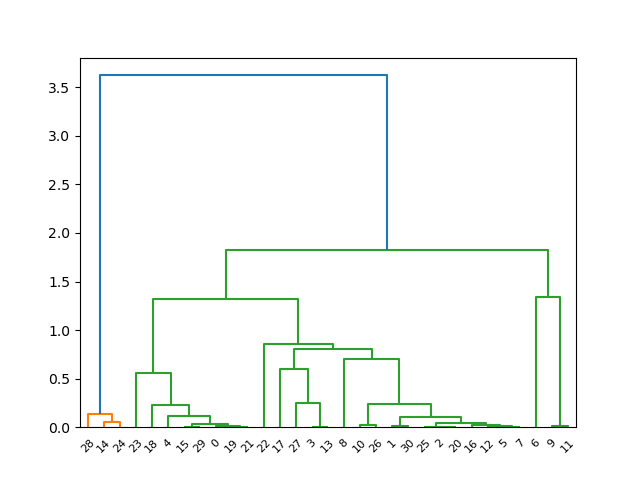

In [81]:
df_post_linkage, meta_data_df, linkage_cluster_order = dp.inter_cluster_sort(df_pre_linkage,meta_data_df, unique_labels,n_components = 10)

In [86]:
df_post_linkage.head()

,TGCACGGGTGCACATT-1_10X51_2,TACCTGCGTATGAAAC-1_10X36_2,TAGACTGTCCTTATAC-1_10X36_2,GACAGCCGTGCGAGTA-1_10X35_2,ATTTCTGAGTGCACTT-1_10X35_1,TCCTTTCCAATCTCTT-1_10X35_1,TCTGGCTTCACCTTGC-1_10X36_2,TGTGATGTCGTCCTTG-1_10X35_2,TGACTCCTCGTCGATA-1_10X35_1,TGCACGGCATGATAGA-1_10X35_2,...,CATGGTACAGAACTAA-1_10X35_1,ATCCACCAGCACCCAC-1_10X35_1,TTGCGTCAGTGATGGC-1_10X52_3,ATCTCTATCGTTCAGA-1_10X35_1,CCTGTTGTCGAAATCC-1_10X51_2,TTTGATCCACCCTATC-1_10X51_1,TATCTGTAGTGAGTGC-1_10X37_2,TCAAGCAGTAGGAAAG-1_10X51_2,CCCTCAACAACGCATT-1_10X51_2,GCATCGGTCTTCTCAA-1_10X36_1
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Plp1,157,140,295,246,82,202,324,430,284,227,...,1,0,1,0,0,0,0,0,0,0
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
meta_data_df.tail()

,TGCACGGGTGCACATT-1_10X51_2,TACCTGCGTATGAAAC-1_10X36_2,TAGACTGTCCTTATAC-1_10X36_2,GACAGCCGTGCGAGTA-1_10X35_2,ATTTCTGAGTGCACTT-1_10X35_1,TCCTTTCCAATCTCTT-1_10X35_1,TCTGGCTTCACCTTGC-1_10X36_2,TGTGATGTCGTCCTTG-1_10X35_2,TGACTCCTCGTCGATA-1_10X35_1,TGCACGGCATGATAGA-1_10X35_2,...,CATGGTACAGAACTAA-1_10X35_1,ATCCACCAGCACCCAC-1_10X35_1,TTGCGTCAGTGATGGC-1_10X52_3,ATCTCTATCGTTCAGA-1_10X35_1,CCTGTTGTCGAAATCC-1_10X51_2,TTTGATCCACCCTATC-1_10X51_1,TATCTGTAGTGAGTGC-1_10X37_2,TCAAGCAGTAGGAAAG-1_10X51_2,CCCTCAACAACGCATT-1_10X51_2,GCATCGGTCTTCTCAA-1_10X36_1
LIbConstructionComment,,,,,,,,,,,...,,,,,,,,,,
ngperul_seqlib,22.2,12.1,12.1,17.6,13.6,13.6,12.1,17.6,13.6,17.6,...,13.6,13.6,20.4(second prep),13.6,22.2,19.2,16.0,22.2,22.2,11.4
lengthbp_seqlib,474.0,486.0,486.0,461.0,416.0,416.0,486.0,461.0,416.0,461.0,...,416.0,416.0,507.0,416.0,474.0,478.0,460.0,474.0,474.0,476.0
Sample_Index,A2,A9,A9,G8,D9,D9,A9,G8,D9,G8,...,D9,D9,F12,D9,A2,G1,F9,A2,A2,H8
cluster_label,28,28,28,28,28,28,28,28,28,28,...,11,11,11,11,11,11,11,11,11,11


verify cluster labels in metadata match linkage_cluster_order

In [84]:
l, idx = np.unique(np.array(meta_data_df.loc['cluster_label',:]), return_index=True)
l_ordered = l[np.argsort(idx)]
l_ordered

array([28, 14, 24, 23, 18, 4, 15, 29, 0, 19, 21, 22, 17, 27, 3, 13, 8, 10,
       26, 1, 30, 25, 2, 20, 16, 12, 5, 7, 6, 9, 11], dtype=object)

### Intra Cluster sorting <a name="intra_cluster_sort"></a>

Intra cluster sorting  - For every unique cluster, perform 1D tsne, then use ascending TSNE values reshuffle within cluster

In [93]:
df_post_linkage_intra_sorted, meta_data_df, cluster_indices = dp.intra_cluster_sort(df_post_linkage, meta_data_df, linkage_cluster_order)

In [94]:
df_post_linkage_intra_sorted.head()

,CGGAACCCAATTGCGT-1_10X52_4,CTCCTTTGTACACTCA-1_10X52_1,TGTGATGTCGTCCTTG-1_10X35_2,TTCTCTCGTCCGAAGA-1_10X35_1,GACGTTAAGTTGCATC-1_10X38_2,TCTGTCGAGCAAATCA-1_10X52_4,TAGACTGTCCTTATAC-1_10X36_2,TGACTCCTCGTCGATA-1_10X35_1,TCCCATGCACTACACA-1_10X35_1,GACAGCCGTGCGAGTA-1_10X35_2,...,ACAACCACACGACAAG-1_10X38_1,ATGTCCCAGGGAGGTG-1_10X35_1,CATTTCAAGCAGGCAT-1_10X51_1,TTGGGCGAGACGCTCC-1_10X38_1,CAGATCAAGCCGCTTG-1_10X35_1,TAGGTTGAGGCCCACT-1_10X51_1,ACAAAGAGTACAGTTC-1_10X36_1,AACCAACGTATTAAGG-1_10X38_1,ATTCCATGTGTTACAC-1_10X36_2,CACGTTCAGGTAGCCA-1_10X37_1
gene,,,,,,,,,,,,,,,,,,,,,
Hbb-bs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Oxt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Avp,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
Plp1,111,121,430,359,335,274,295,284,235,246,...,0,1,1,0,0,0,0,0,2,1
Hba-a1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:
meta_data_df.tail()

,CGGAACCCAATTGCGT-1_10X52_4,CTCCTTTGTACACTCA-1_10X52_1,TGTGATGTCGTCCTTG-1_10X35_2,TTCTCTCGTCCGAAGA-1_10X35_1,GACGTTAAGTTGCATC-1_10X38_2,TCTGTCGAGCAAATCA-1_10X52_4,TAGACTGTCCTTATAC-1_10X36_2,TGACTCCTCGTCGATA-1_10X35_1,TCCCATGCACTACACA-1_10X35_1,GACAGCCGTGCGAGTA-1_10X35_2,...,ACAACCACACGACAAG-1_10X38_1,ATGTCCCAGGGAGGTG-1_10X35_1,CATTTCAAGCAGGCAT-1_10X51_1,TTGGGCGAGACGCTCC-1_10X38_1,CAGATCAAGCCGCTTG-1_10X35_1,TAGGTTGAGGCCCACT-1_10X51_1,ACAAAGAGTACAGTTC-1_10X36_1,AACCAACGTATTAAGG-1_10X38_1,ATTCCATGTGTTACAC-1_10X36_2,CACGTTCAGGTAGCCA-1_10X37_1
LIbConstructionComment,,,,,,,,,,,...,,,,,,,,,,
ngperul_seqlib,8.94 (second prep),15.7,17.6,13.6,18.7,8.94 (second prep),12.1,13.6,13.6,17.6,...,15.0,13.6,19.2,15.0,13.6,19.2,11.4,15.0,12.1,15.9
lengthbp_seqlib,535.0,466.0,461.0,416.0,415.0,535.0,486.0,416.0,416.0,461.0,...,420.0,416.0,478.0,420.0,416.0,478.0,476.0,420.0,486.0,440.0
Sample_Index,G12,D12,G8,D9,C9,G12,A9,D9,D9,G8,...,B9,D9,G1,B9,D9,G1,H8,B9,A9,E9
cluster_label,28,28,28,28,28,28,28,28,28,28,...,11,11,11,11,11,11,11,11,11,11


Verify cluster_label in meta data are still in same order (inter cluster order remains the same)

In [125]:
l, idx = np.unique(np.array(meta_data_df.loc['cluster_label',:]), return_index=True)
l_ordered = l[np.argsort(idx)]
l_ordered

array([28, 14, 24, 23, 18, 4, 15, 29, 0, 19, 21, 22, 17, 27, 3, 13, 8, 10,
       26, 1, 30, 25, 2, 20, 16, 12, 5, 7, 6, 9, 11], dtype=object)

In [106]:
df_post_linkage_intra_sorted.shape

(744, 42652)

## Marker Genes<a name="markergenes"></a>

In [126]:
unique_labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

In [127]:
for c, idx in zip(linkage_cluster_order,cluster_indices):
    print (f'cluster {c}, num_cells {len(idx)}')

cluster 28, num_cells 89
cluster 14, num_cells 724
cluster 24, num_cells 138
cluster 23, num_cells 292
cluster 18, num_cells 156
cluster 4, num_cells 12798
cluster 15, num_cells 539
cluster 29, num_cells 81
cluster 0, num_cells 1667
cluster 19, num_cells 162
cluster 21, num_cells 328
cluster 22, num_cells 37
cluster 17, num_cells 193
cluster 27, num_cells 41
cluster 3, num_cells 806
cluster 13, num_cells 272
cluster 8, num_cells 1038
cluster 10, num_cells 451
cluster 26, num_cells 35
cluster 1, num_cells 9859
cluster 30, num_cells 76
cluster 25, num_cells 40
cluster 2, num_cells 8557
cluster 20, num_cells 70
cluster 16, num_cells 70
cluster 12, num_cells 712
cluster 5, num_cells 1625
cluster 7, num_cells 460
cluster 6, num_cells 100
cluster 9, num_cells 760
cluster 11, num_cells 467


### Compute Markers <a name="compute_marker_genes"></a>

In [101]:
marker_genes_sorted, pos = dp.compute_marker_genes(df_post_linkage_intra_sorted,
                                                meta_data_df,
                                                cluster_indices,
                                                linkage_cluster_order,
                                                n_markers=5)

/home/isaac/analysis/scRNA-seq/dimorph_processing.py:647: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/isaac/analysis/scRNA-seq/dimorph_processing.py:652: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
/home/isaac/analysis/scRNA-seq/dimorph_processing.py:657: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


[  0   1   2   3   4 128   6  14  13  12  11   9   8   7   5  10  20  21
  19 107  17  15  18  16  23  45  22  60  40  27  26  24  28  35  36  42
  48  47  46  43  49  44  41  54  50  51  52  58  56  55  30  61  59  57
  39  65  62  63  64  69  66  67  68 122  75  74  73  71  70  72 139 138
  79 141  76  77  78  80  81  82  32  85 129 117  33  34 135  29 134  31
  88  87  38  90  86 144  37 132 124  89  91  95  94  93  92 101  96  98
 100  97 102 103  99  53 105 109 110 104 114 116 115 108 113 112 111 106
 120 121 119 127 126 125 130 140 133 123 136 137 142 131 145 146 147 148
 149 150  25 143 151 152 153 157 156 158 155  83  84 118 154 175 174 173
 172 171 170 169 167 166 164 163 162 161 160 159 176 165 177 168]
len marker_genes_sorted_final 178


In [102]:
list(marker_genes_sorted)

['Itih3',
 'Slc7a10',
 'Ptgds',
 'Il33',
 'Gjb6',
 'Cd63',
 'Agt',
 'Plp1',
 'Mobp',
 'Mal',
 'Aspa',
 'Ermn',
 'Opalin',
 'Mog',
 'Trf',
 'Gjb1',
 'Bcas1',
 'Bfsp2',
 'Bmp4',
 'Neu4',
 'Cnksr3',
 'Folr2',
 'Gpr17',
 'Enpp6',
 'Gabre',
 'Arx',
 'Calcr',
 'Satb1',
 'Slc32a1',
 'Prlr',
 'Cbln1',
 'Cartpt',
 'Plagl1',
 'Nfib',
 'Nfix',
 'Dlx6os1',
 'Ndnf',
 'Egfr',
 'Cplx3',
 'Pnoc',
 'Kit',
 'Gad1',
 'Gad2',
 'Maf',
 'Hapln1',
 'Cort',
 'Cox6a2',
 'Igfbp4',
 'Npy',
 'Crhbp',
 'Moxd1',
 'Cbln4',
 'BC048546',
 'Sst',
 'Dlx1',
 'Th',
 'Lhx6',
 'Lhx8',
 'Slc10a4',
 'Elfn1',
 'Tacr3',
 'Crh',
 'Shisa8',
 'Rasl11a',
 'Tpm2',
 'Myh11',
 'Cnn1',
 'Acta2',
 'Tagln',
 'Pln',
 'Fos',
 'Btg2',
 'Cx3cr1',
 'Junb',
 'Bcl2a1b',
 'C1qc',
 'Siglech',
 'C1qa',
 'C1qb',
 'Ctss',
 'Car12',
 'Crym',
 'Krt9',
 'Bhlhe22',
 'Lpl',
 'Nptx1',
 'Penk',
 'Vgll3',
 'Ngb',
 'Cd24a',
 'C1ql1',
 'Pou3f1',
 'Neurod2',
 'Cbln2',
 'Sim1',
 'Igfbp5',
 'Slc17a7',
 'Rmst',
 '3110035E14Rik',
 'Cyp26b1',
 'Neurod6',
 'Ntng1',


In [103]:
df_marker = df_post_linkage_intra_sorted.loc[marker_genes_sorted,:]

In [104]:
df_marker.shape

(178, 42643)

In [105]:
df_marker.head()

,CGGAACCCAATTGCGT-1_10X52_4,CTCCTTTGTACACTCA-1_10X52_1,TGTGATGTCGTCCTTG-1_10X35_2,TTCTCTCGTCCGAAGA-1_10X35_1,GACGTTAAGTTGCATC-1_10X38_2,TCTGTCGAGCAAATCA-1_10X52_4,TAGACTGTCCTTATAC-1_10X36_2,TGACTCCTCGTCGATA-1_10X35_1,TCCCATGCACTACACA-1_10X35_1,GACAGCCGTGCGAGTA-1_10X35_2,...,ACAACCACACGACAAG-1_10X38_1,ATGTCCCAGGGAGGTG-1_10X35_1,CATTTCAAGCAGGCAT-1_10X51_1,TTGGGCGAGACGCTCC-1_10X38_1,CAGATCAAGCCGCTTG-1_10X35_1,TAGGTTGAGGCCCACT-1_10X51_1,ACAAAGAGTACAGTTC-1_10X36_1,AACCAACGTATTAAGG-1_10X38_1,ATTCCATGTGTTACAC-1_10X36_2,CACGTTCAGGTAGCCA-1_10X37_1
gene,,,,,,,,,,,,,,,,,,,,,
Itih3,0,17,1,3,0,1,1,6,0,1,...,0,0,0,0,0,0,0,0,0,0
Slc7a10,1,2,2,2,0,1,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
Ptgds,24,30,0,0,0,1,27,87,8,44,...,1,1,0,0,0,0,0,0,0,0
Il33,1,6,0,0,0,0,2,8,4,2,...,0,0,0,0,0,0,0,0,0,0
Gjb6,3,1,2,0,0,0,2,6,0,0,...,0,0,0,0,0,0,0,0,0,0


### Heatmap <a name="marker_heatmap"></a>

First, standerdize the marker dataframe

In [106]:
marker_log_and_std_arr, status_df = dp.log_and_standerdize_df(df_marker,status_df, log = False)

column (gene) mean after standardization: -0.00
column (gene) sigma after standardization: 1.00


In [107]:
marker_log_and_std_arr.T.shape

(178, 42643)

In [108]:
df_marker_log_and_std = pd.DataFrame(index = df_marker.index, columns=df_post_linkage_intra_sorted.columns, data = marker_log_and_std_arr.T)

In [115]:
df_marker_log_and_std.shape

(178, 42643)

In [109]:
df_marker_log_and_std.head()

,CGGAACCCAATTGCGT-1_10X52_4,CTCCTTTGTACACTCA-1_10X52_1,TGTGATGTCGTCCTTG-1_10X35_2,TTCTCTCGTCCGAAGA-1_10X35_1,GACGTTAAGTTGCATC-1_10X38_2,TCTGTCGAGCAAATCA-1_10X52_4,TAGACTGTCCTTATAC-1_10X36_2,TGACTCCTCGTCGATA-1_10X35_1,TCCCATGCACTACACA-1_10X35_1,GACAGCCGTGCGAGTA-1_10X35_2,...,ACAACCACACGACAAG-1_10X38_1,ATGTCCCAGGGAGGTG-1_10X35_1,CATTTCAAGCAGGCAT-1_10X51_1,TTGGGCGAGACGCTCC-1_10X38_1,CAGATCAAGCCGCTTG-1_10X35_1,TAGGTTGAGGCCCACT-1_10X51_1,ACAAAGAGTACAGTTC-1_10X36_1,AACCAACGTATTAAGG-1_10X38_1,ATTCCATGTGTTACAC-1_10X36_2,CACGTTCAGGTAGCCA-1_10X37_1
gene,,,,,,,,,,,,,,,,,,,,,
Itih3,-0.114879,39.466472,2.213436,6.870066,-0.114879,2.213436,2.213436,13.855010,-0.114879,2.213436,...,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879
Slc7a10,3.246184,6.615714,6.615714,6.615714,-0.123346,3.246184,-0.123346,13.354774,-0.123346,-0.123346,...,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346
Ptgds,1.970669,2.491133,-0.111185,-0.111185,-0.111185,-0.024441,2.230901,7.435536,0.582767,3.705547,...,-0.024441,-0.024441,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185
Il33,1.581697,10.146994,-0.131363,-0.131363,-0.131363,-0.131363,3.294756,13.573113,6.720875,3.294756,...,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363
Gjb6,8.993260,2.910599,5.951929,-0.130731,-0.130731,-0.130731,5.951929,18.117250,-0.130731,-0.130731,...,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731


Write to file

In [110]:
pwd

'/home/isaac/analysis/scRNA-seq'

In [111]:
#outfile_name = 'df_marker_log_and_std'
#df_marker_log_and_std.to_feather('/bigdata/isaac/'+outfile_name+'.feather')
#df_marker_log_and_std = pd.read_feather('/bigdata/isaac/df_marker_log_and_std.feather')

In [112]:
#outfile_name = 'metadata_df_marker_log_and_std'
#meta_data_df.to_json('/bigdata/isaac/'+outfile_name+'.json')
#metadata_df_marker_log_and_std = pd.read_json('/bigdata/isaac/metadata_df_marker_log_and_std.json')

<IPython.core.display.Javascript object>


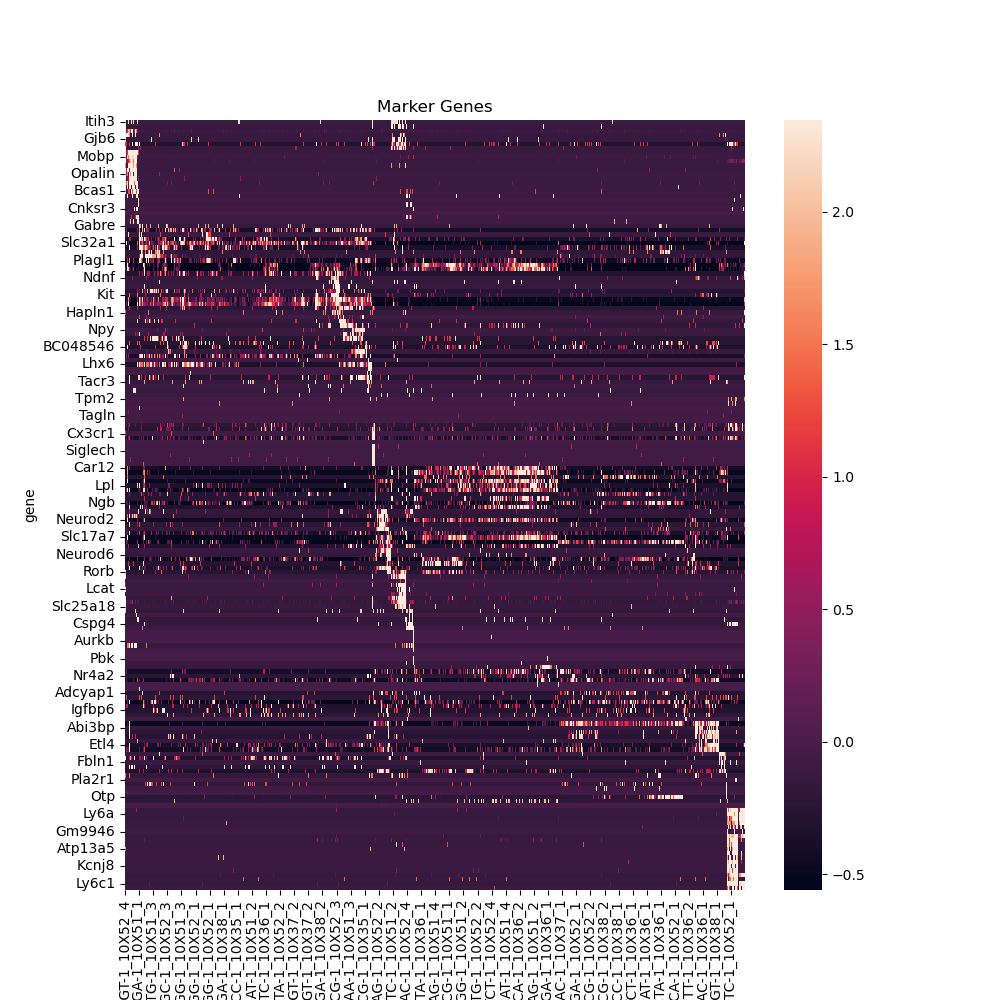

In [118]:
ax, fig = plt.subplots(figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
#to display all ticks, use: xticklabels=True, yticklabels=True
plt.title('Marker Genes')
sns.heatmap(df_marker_log_and_std, robust=True)
plt.show()

Update plot to show average cluster position

In [119]:
df_marker_log_and_std_col = pd.DataFrame(data = df_marker_log_and_std.to_numpy(), 
                                         index = df_marker_log_and_std.index,
                                        columns = list(meta_data_df.loc['cluster_label',:]))

In [120]:
df_marker_log_and_std_col

,28,28,28,28,28,28,28,28,28,28,...,11,11,11,11,11,11,11,11,11,11
gene,,,,,,,,,,,,,,,,,,,,,
Itih3,-0.114879,39.466472,2.213436,6.870066,-0.114879,2.213436,2.213436,13.855010,-0.114879,2.213436,...,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879,-0.114879
Slc7a10,3.246184,6.615714,6.615714,6.615714,-0.123346,3.246184,-0.123346,13.354774,-0.123346,-0.123346,...,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346,-0.123346
Ptgds,1.970669,2.491133,-0.111185,-0.111185,-0.111185,-0.024441,2.230901,7.435536,0.582767,3.705547,...,-0.024441,-0.024441,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185,-0.111185
Il33,1.581697,10.146994,-0.131363,-0.131363,-0.131363,-0.131363,3.294756,13.573113,6.720875,3.294756,...,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363,-0.131363
Gjb6,8.993260,2.910599,5.951929,-0.130731,-0.130731,-0.130731,5.951929,18.117250,-0.130731,-0.130731,...,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731,-0.130731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vtn,-0.103721,-0.103721,-0.103721,-0.103721,-0.103721,-0.103721,-0.103721,-0.103721,-0.103721,-0.103721,...,-0.103721,-0.103721,-0.103721,-0.103721,0.737388,-0.103721,1.157943,-0.103721,0.316834,-0.103721
Flt1,-0.144445,-0.144445,-0.144445,-0.144445,-0.144445,-0.144445,0.038440,-0.144445,-0.144445,-0.144445,...,7.170973,11.194453,13.937734,8.451171,7.353858,17.412558,8.999827,7.536744,15.583703,12.108880
Ndufa4l2,-0.128273,-0.128273,-0.128273,-0.128273,-0.128273,-0.128273,-0.128273,-0.128273,-0.128273,-0.128273,...,-0.128273,-0.128273,1.399222,-0.128273,-0.128273,1.399222,1.399222,-0.128273,1.399222,-0.128273


In [121]:
np.sort(linkage_cluster_order)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30])

<IPython.core.display.Javascript object>


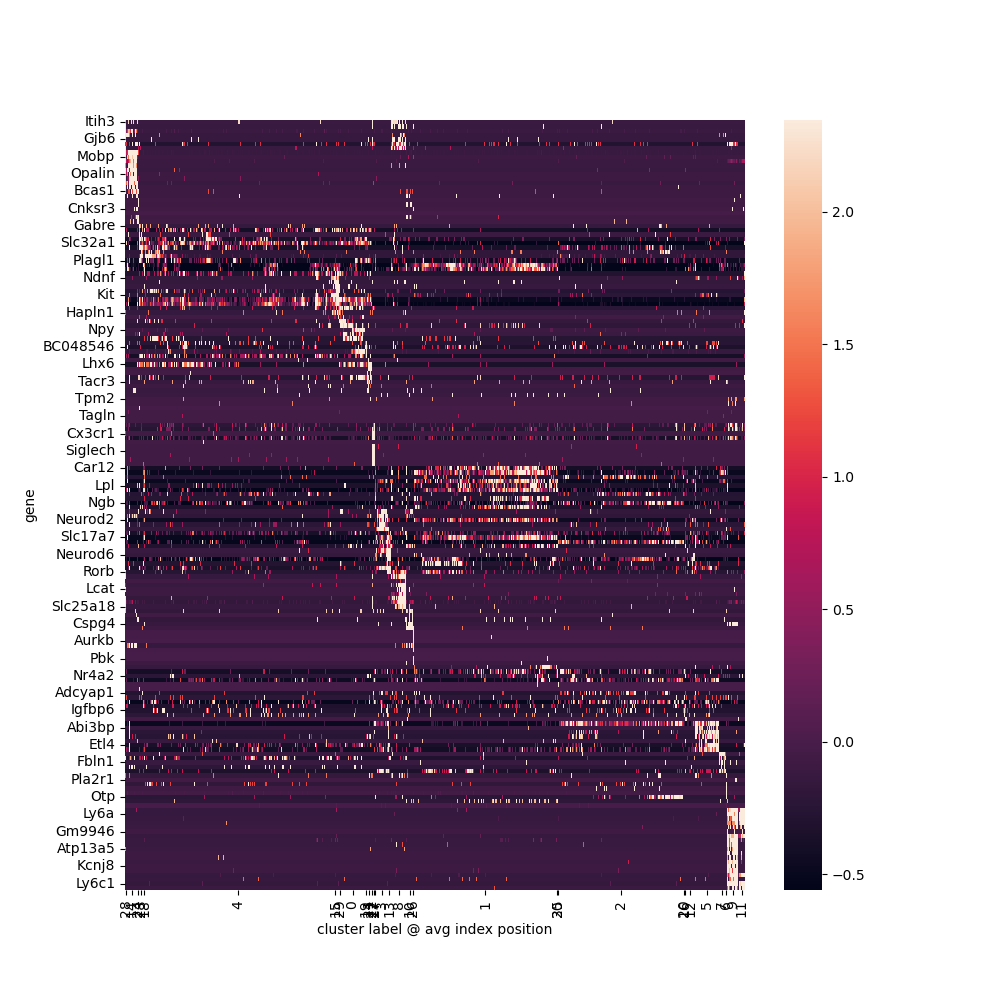

In [122]:
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(df_marker_log_and_std_col, robust=True)
ax.set_xticks(ticks = pos, labels = linkage_cluster_order)
ax.set_xlabel('cluster label @ avg index position')
plt.show()

<IPython.core.display.Javascript object>


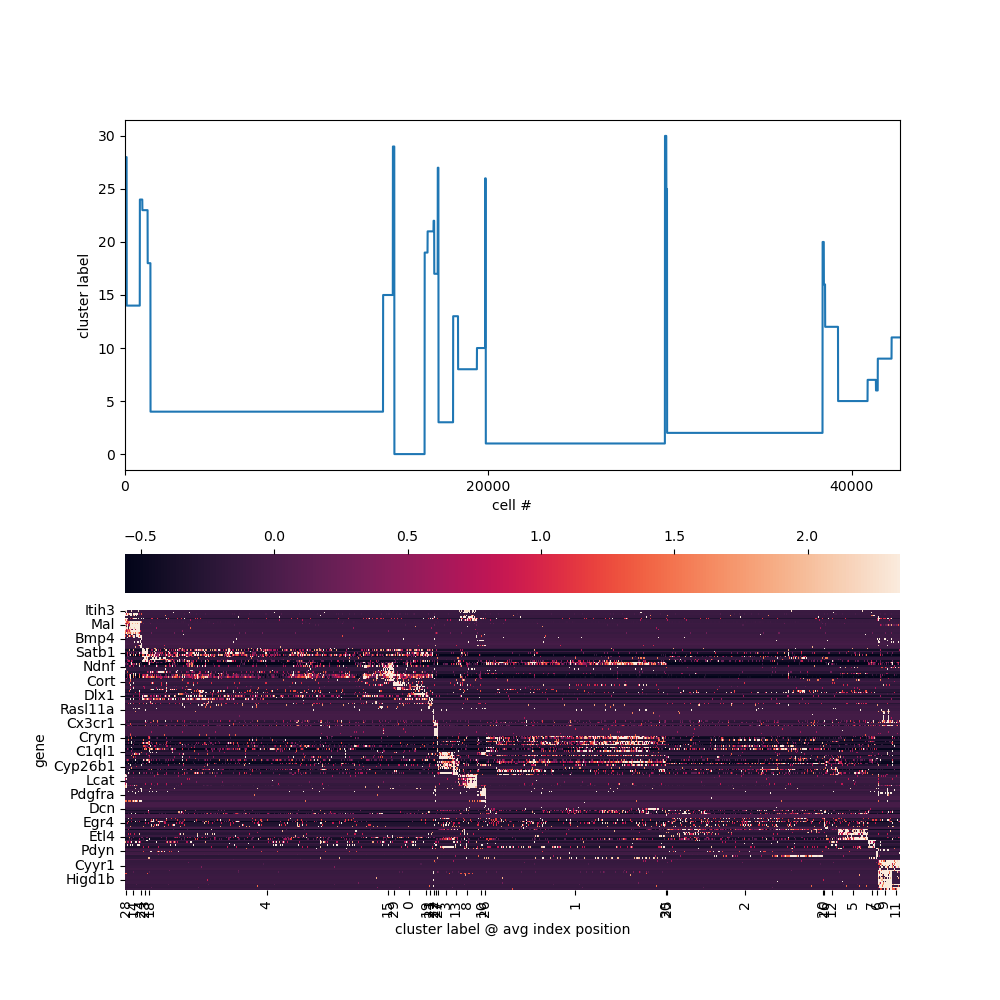

In [123]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize = (10,10))
#set robust to True causes Seaborn to set the bounds of the color scale at the 2nd and 98th percentile values
#to display all ticks, use: xticklabels=True, yticklabels=True

ax1.plot(np.array(meta_data_df.loc['cluster_label',:]))
ax1.set_xticks(ticks = [0, 20000, 40000])
ax1.margins(x=0)
ax1.set_xlabel('cell #')
ax1.set_ylabel('cluster label')

#plt.title('Heatmap using  column major F style')
#to move colorbar to top, add code below to .heatmap call
#cbar_kws=dict(location = 'top')
ax2 = sns.heatmap(df_marker_log_and_std_col, robust=True,cbar_kws=dict(location = 'top'))
ax2.set_xticks(ticks = pos, labels = linkage_cluster_order)
ax2.set_xlabel('cluster label @ avg index position')

plt.show()

Further analysis

In [153]:
list(marker_genes_sorted)

['Itih3',
 'Slc7a10',
 'Ptgds',
 'Il33',
 'Gjb6',
 'Cd63',
 'Agt',
 'Plp1',
 'Mobp',
 'Mal',
 'Aspa',
 'Ermn',
 'Opalin',
 'Mog',
 'Trf',
 'Gjb1',
 'Bcas1',
 'Bfsp2',
 'Bmp4',
 'Neu4',
 'Cnksr3',
 'Folr2',
 'Gpr17',
 'Enpp6',
 'Gabre',
 'Arx',
 'Calcr',
 'Satb1',
 'Slc32a1',
 'Prlr',
 'Cbln1',
 'Cartpt',
 'Plagl1',
 'Nfib',
 'Nfix',
 'Dlx6os1',
 'Egfr',
 'Cplx3',
 'Gad1',
 'Pnoc',
 'Kit',
 'Ndnf',
 'Gad2',
 'Maf',
 'Hapln1',
 'Cort',
 'Cox6a2',
 'Igfbp4',
 'Moxd1',
 'Npy',
 'Crhbp',
 'BC048546',
 'Sst',
 'Dlx1',
 'Th',
 'Elfn1',
 'Shisa8',
 'Lhx6',
 'Lhx8',
 'Slc10a4',
 'Crh',
 'Tacr3',
 'Myh11',
 'Cnn1',
 'Pln',
 'Acta2',
 'Tagln',
 'Btg2',
 'Rasl11a',
 'Tpm2',
 'Fos',
 'Cx3cr1',
 'C1qa',
 'Siglech',
 'C1qb',
 'Ctss',
 'Bcl2a1b',
 'Junb',
 'C1qc',
 'Cd24a',
 'Vgll3',
 'Nptx1',
 'Lpl',
 'Car12',
 'Penk',
 'Crym',
 'Bhlhe22',
 'Krt9',
 'Ngb',
 'Neurod2',
 'C1ql1',
 'Sim1',
 'Cbln2',
 'Pou3f1',
 'Rmst',
 'Igfbp5',
 '3110035E14Rik',
 'Cyp26b1',
 'Rasgrp1',
 'Neurod6',
 'Krt12',
 'Ntng1',


gene in df?  True
gene index:  [0]


<IPython.core.display.Javascript object>


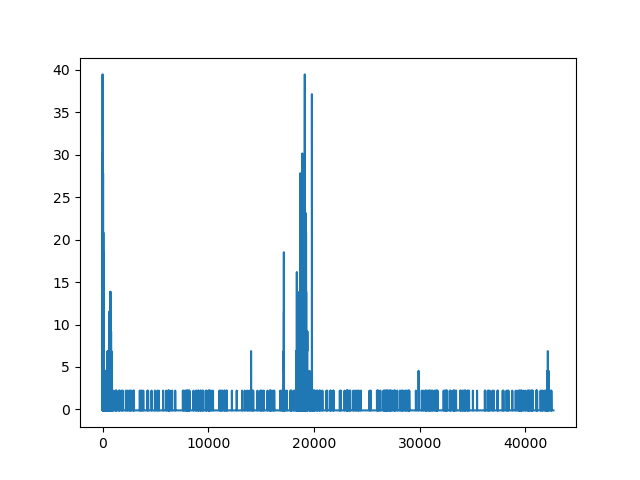

In [164]:
gene = 'Itih3'
print('gene in df? ', gene in df_marker_log_and_std.index)
gene_index = np.where(df_marker_log_and_std.index == gene)[0]
print ('gene index: ', gene_index)
#get row data
x = df_marker_log_and_std.iloc[gene_index,:]
fig,ax = plt.subplots()
plt.plot(np.array(x.iloc[0,:]))
plt.show()